# NN draw

In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from jaxopt import ProjectedGradient

In [2]:
from bayesopt import test_functions, eval_fn, agents
from rebayes_mini.methods import low_rank_last_layer as lrll

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

## The model objective function

In [4]:
class TrueMLP(nn.Module):
    n_hidden: int = 50

    def setup(self):
        self.hidden_1 = nn.Dense(50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.hidden_2 = nn.Dense(50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.last = nn.Dense(1,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

    def __call__(self, x):
        x = self.hidden_1(x)
        x = nn.relu(x)
        x = self.hidden_2(x)
        x = nn.relu(x)
        x = self.last(x)
        return x

In [150]:
key = jax.random.PRNGKey(3141)
key_init, key_surrogate = jax.random.split(key)

In [151]:
dim = 200 # change to 200
X_init = jnp.ones((1, dim))

base_model = TrueMLP()
params_base = base_model.init(key_init, X_init)

In [152]:
def objective_fn(x):
    return -base_model.apply(params_base, x)

In [153]:
def plot_hist(ax, runs, color=None, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    color_plot = "black" if color is None else color
    color_fill = "tab:gray" if color is None else color
    
    ax.plot(med_run, c=color_plot, **kwargs)
    ax.fill_between(steps, lbound, ubound, color=color_fill, alpha=0.4)

In [154]:
key_init_params, key_run = jax.random.split(key_surrogate)

## Best optimum (projected gradient descent)

In [185]:
opt = ProjectedGradient(
    fun=lambda x: -base_model.apply(params_base, x).squeeze(),
    projection=partial(eval_fn.projection, lbound=0.0, ubound=1.0),  # Enforce boundary constraints
    stepsize=1e-7,
    maxiter=8000
)

guess_init = jax.random.uniform(key_run, dim) # intial guess per run
res = opt.run(init_params=guess_init)

In [186]:
yopt = base_model.apply(params_base, res.params)
yopt

Array([1663.5686], dtype=float32)

## LL-LRKF

In [202]:
agent, bel_init_fn = agents.load_ll_lrkf_agent(
    key_init_params, X_init, rank=10, cov_hidden=1e-4, cov_last=0.1,
)

In [203]:
%%time
n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
runs = jax.tree.map(np.array, runs)

CPU times: user 37.5 s, sys: 1 s, total: 38.5 s
Wall time: 27.8 s


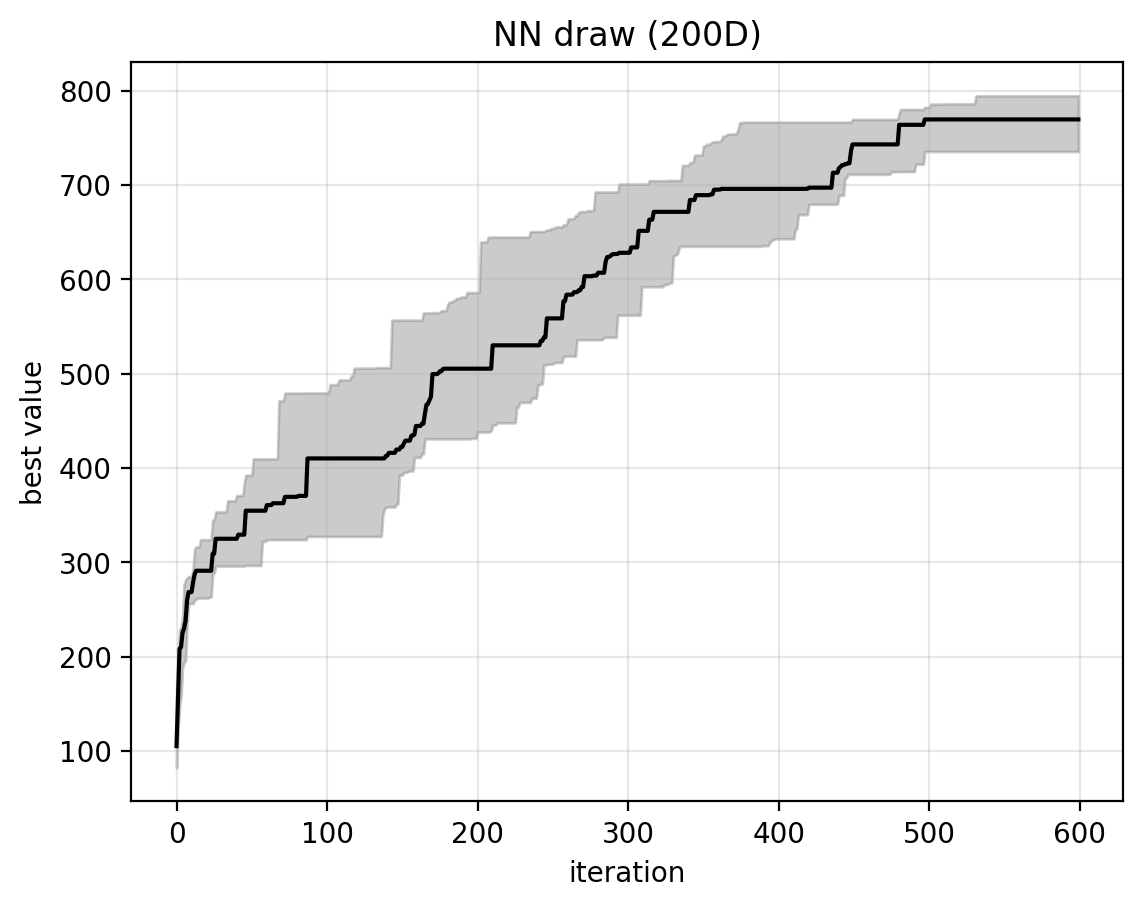

In [204]:
fig, ax = plt.subplots()
plot_hist(ax, runs["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## Run multiple dims

In [182]:
%%time
ranks = [0, 1, 10, 50, 100, 150]
n_steps = 600
n_runs = 20
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)

runs_all = {}
for rank in ranks:
    print(rank, end="\r")
    
    agent, bel_init_fn = agents.load_ll_lrkf_agent(
        key_init_params, X_init, rank=rank, cov_hidden=1e-4, cov_last=0.01,
    )    

    runs = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
    runs = jax.tree.map(np.array, runs)
    runs_all[rank] = runs

CPU times: user 4min 38s, sys: 9.55 s, total: 4min 48s
Wall time: 3min 30s


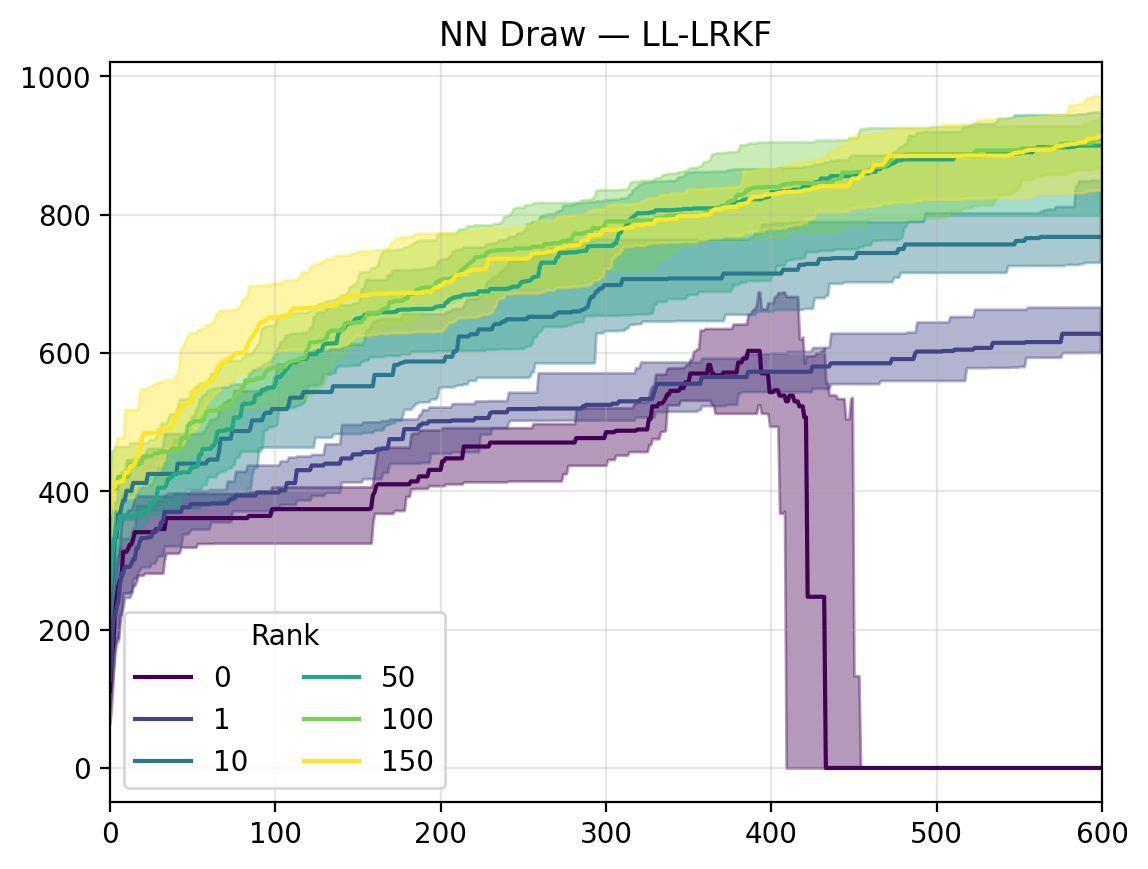

In [184]:
fig, ax = plt.subplots()

colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
for color, rank in zip(colors, ranks):
    plot_hist(ax, runs_all[rank]["y_best"], color=color, label=rank)
plt.legend(title="Rank", ncols=2)
# plt.ylim(bottom=800)
plt.xlim(left=0.0, right=n_steps)
plt.title("NN Draw — LL-LRKF")
plt.grid(alpha=0.3)

## LoFi

In [207]:
agent, bel_init_fn = agents.load_lofi_agent(
    key_init_params, X_init, rank=10, cov_init=1e-6, obs_noise=1.0, dynamics_covariance=1e-5
)

In [ ]:
%%time
n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
runs = jax.tree.map(np.array, runs)

In [ ]:
fig, ax = plt.subplots()
plot_hist(ax, runs["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

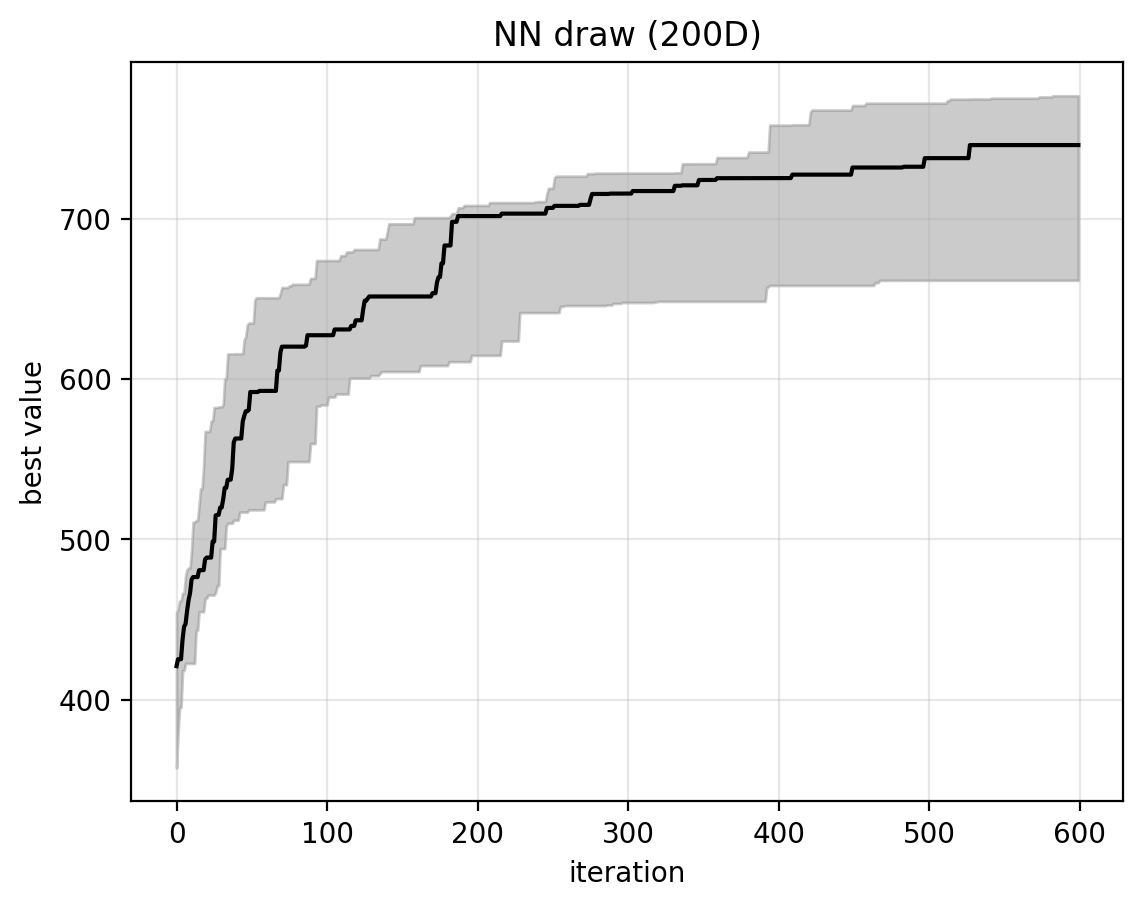

In [163]:
fig, ax = plt.subplots()
plot_hist(ax, runs["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));